# MobileNet transfer learning

Pilot dataset mobile using transfer learning from the mobilenet architecture

## Config

In [43]:
import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV3Small, MobileNetV3Large
from tensorflow.keras.layers import RandomRotation, RandomFlip, RandomZoom, Dropout, Dense, Input
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.losses import BinaryCrossentropy
import matplotlib.pyplot as plt
import os
from pathlib import Path

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['font.size'] = 12

In [44]:
# NOTEBOOK PARAMETERS
output_path_MN_small = '../models/pilot_mobilenet-v3-xfer/v1_poison_ivy_mobilenet-v3-small_classifier'
output_path_MN_large = '../models/pilot_mobilenet-v3-xfer/v1_poison_ivy_mobilenet-v3-large_classifier'

train_path = '../datasets/pilot_final/train'
val_path = '../datasets/pilot_final/val'

image_size = (224, 224)
batch_size = 16
dropout_rate = 0.2

epochs = {
    'top_layer': 500,
    'fine_tuning': 500
}

learning_rates = {
    'top_layer': 0.0001,
    'fine_tuning': 0.000005
}

fine_tune_unfreeze_frac = 0.3

In [3]:
input_shape = (*image_size, 3)

## Datasets

In [4]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_path,
                                                            shuffle=True,
                                                            batch_size=batch_size,
                                                            image_size=image_size)

val_dataset = tf.keras.utils.image_dataset_from_directory(val_path,
                                                          shuffle=True,
                                                          batch_size=batch_size,
                                                          image_size=image_size)

Found 124 files belonging to 2 classes.
Found 32 files belonging to 2 classes.


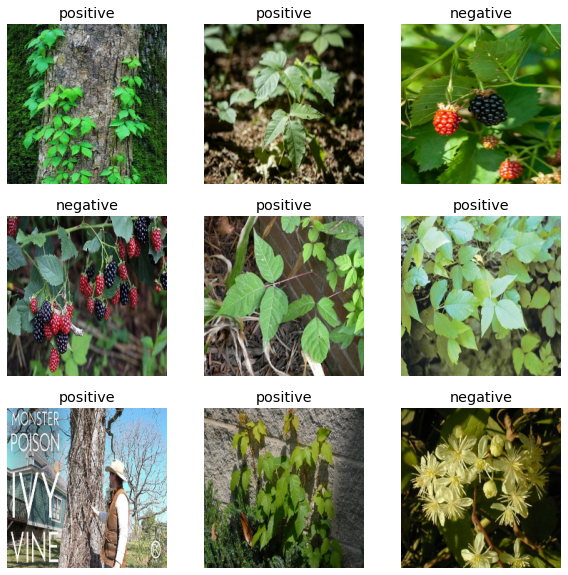

In [5]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Processing layers

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)

### Image augmentation

In [7]:
image_aug = Sequential([
    RandomFlip('horizontal'),
    RandomRotation(0.2),
    RandomZoom(0.1)
])

### Mobilenet

In [8]:
mobilenet_small = MobileNetV3Small(input_shape=input_shape,
                             include_top=False,
                             weights='imagenet',
                             pooling='avg',
                             include_preprocessing=True,
                             dropout_rate=dropout_rate)

mobilenet_small.trainable = False
mobilenet_small.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 16) 432         rescaling[0][0]                  
__________________________________________________________________________________________________
Conv/BatchNorm (BatchNormalizat (None, 112, 112, 16) 64          Conv[0][0]                       
___________________________________________________________________________________

In [9]:
mobilenet_large = MobileNetV3Large(input_shape=input_shape,
                                   include_top=False,
                                   weights='imagenet',
                                   pooling='avg',
                                   include_preprocessing=True,
                                   dropout_rate=dropout_rate)

mobilenet_large.trainable = False
mobilenet_large.summary()

Model: "MobilenetV3large"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 224, 224, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 16) 432         rescaling_1[0][0]                
__________________________________________________________________________________________________
Conv/BatchNorm (BatchNormalizat (None, 112, 112, 16) 64          Conv[0][0]                       
___________________________________________________________________________________

## Create Models

In [10]:
def build_model(mobilenet):
    inputs = Input(shape=input_shape)
    x = image_aug(inputs)
    x = mobilenet(x, training=False)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(1)(x)
    
    return(Model(inputs, outputs))
    

In [11]:
model_small = build_model(mobilenet_small)
model_large = build_model(mobilenet_large)

In [12]:
model_small.compile(optimizer=Adam(learning_rate=learning_rates['top_layer']),
                    loss=BinaryCrossentropy(from_logits=True),
                    metrics=['accuracy'])
model_large.compile(optimizer=Adam(learning_rate=learning_rates['top_layer']),
                    loss=BinaryCrossentropy(from_logits=True),
                    metrics=['accuracy'])

In [13]:
model_small.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
MobilenetV3small (Functional (None, 1024)              1529968   
_________________________________________________________________
dense (Dense)                (None, 512)               524800    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 2,055,281
Trainable params: 525,313
Non-trainable params: 1,529,968
_____________________________________________

In [14]:
model_large.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
MobilenetV3large (Functional (None, 1280)              4226432   
_________________________________________________________________
dense_2 (Dense)              (None, 512)               655872    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 513       
Total params: 4,882,817
Trainable params: 656,385
Non-trainable params: 4,226,432
___________________________________________

## Fit Base Models

In [15]:
early_stopping = EarlyStopping(patience=10, restore_best_weights=False)
reduce_lr = ReduceLROnPlateau(patience=3, factor=1./3.)
callbacks = [early_stopping, reduce_lr]

In [16]:
history_small = model_small.fit(train_dataset,
                                validation_data=val_dataset,
                                epochs=epochs['top_layer'],
                                callbacks=callbacks)

Epoch 1/500
8/8 [==============================] - 8s 250ms/step - loss: 0.7097 - accuracy: 0.4677 - val_loss: 0.5941 - val_accuracy: 0.5312
Epoch 2/500
8/8 [==============================] - 1s 69ms/step - loss: 0.5388 - accuracy: 0.7177 - val_loss: 0.5080 - val_accuracy: 0.7812
Epoch 3/500
8/8 [==============================] - 1s 67ms/step - loss: 0.4892 - accuracy: 0.7984 - val_loss: 0.4554 - val_accuracy: 0.7812
Epoch 4/500
8/8 [==============================] - 1s 68ms/step - loss: 0.4128 - accuracy: 0.8306 - val_loss: 0.4289 - val_accuracy: 0.7812
Epoch 5/500
8/8 [==============================] - 1s 65ms/step - loss: 0.3970 - accuracy: 0.8468 - val_loss: 0.4063 - val_accuracy: 0.8125
Epoch 6/500
8/8 [==============================] - 1s 69ms/step - loss: 0.3455 - accuracy: 0.8629 - val_loss: 0.3911 - val_accuracy: 0.8125
Epoch 7/500
8/8 [==============================] - 1s 85ms/step - loss: 0.3068 - accuracy: 0.8710 - val_loss: 0.3829 - val_accuracy: 0.8125
Epoch 8/500
8/8 [==

In [17]:
history_large = model_large.fit(train_dataset,
                                validation_data=val_dataset,
                                epochs=epochs['top_layer'],
                                callbacks=callbacks)

Epoch 1/500
8/8 [==============================] - 6s 289ms/step - loss: 0.7040 - accuracy: 0.5161 - val_loss: 0.6117 - val_accuracy: 0.7188
Epoch 2/500
8/8 [==============================] - 1s 77ms/step - loss: 0.5040 - accuracy: 0.7661 - val_loss: 0.5343 - val_accuracy: 0.8750
Epoch 3/500
8/8 [==============================] - 1s 83ms/step - loss: 0.4056 - accuracy: 0.8387 - val_loss: 0.4709 - val_accuracy: 0.8750
Epoch 4/500
8/8 [==============================] - 1s 77ms/step - loss: 0.3319 - accuracy: 0.8629 - val_loss: 0.4751 - val_accuracy: 0.8750
Epoch 5/500
8/8 [==============================] - 1s 78ms/step - loss: 0.3013 - accuracy: 0.8387 - val_loss: 0.4709 - val_accuracy: 0.8750
Epoch 6/500
8/8 [==============================] - 1s 79ms/step - loss: 0.2850 - accuracy: 0.8790 - val_loss: 0.4711 - val_accuracy: 0.8750
Epoch 7/500
8/8 [==============================] - 1s 81ms/step - loss: 0.2774 - accuracy: 0.8871 - val_loss: 0.4722 - val_accuracy: 0.8750
Epoch 8/500
8/8 [==

In [18]:
history_small.history['accuracy']

[0.4677419364452362,
 0.7177419066429138,
 0.7983871102333069,
 0.8306451439857483,
 0.8467742204666138,
 0.8629032373428345,
 0.8709677457809448,
 0.8951612710952759,
 0.9112903475761414,
 0.9274193644523621,
 0.9193548560142517,
 0.8951612710952759,
 0.9112903475761414,
 0.9112903475761414,
 0.8951612710952759,
 0.9193548560142517,
 0.9112903475761414,
 0.9435483813285828]

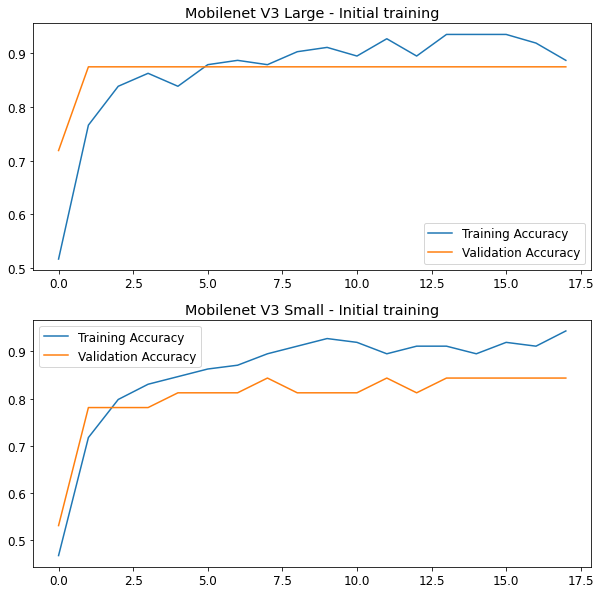

In [19]:
plt.figure(figsize=(10,10))

# Large model
ax = plt.subplot(2,1,1)
plt.plot(history_large.history['accuracy'], label='Training Accuracy')
plt.plot(history_large.history['val_accuracy'], label='Validation Accuracy')
plt.title("Mobilenet V3 Large - Initial training")
plt.legend()

# Small model
plt.subplot(2,1,2, sharex=ax)
plt.plot(history_small.history['accuracy'], label='Training Accuracy')
plt.plot(history_small.history['val_accuracy'], label='Validation Accuracy')
plt.title("Mobilenet V3 Small - Initial training")
plt.legend()

plt.show()

## Fine-tune models

In [20]:
unfreeze_small = int(len(mobilenet_small.layers) * fine_tune_unfreeze_frac)
unfreeze_large = int(len(mobilenet_large.layers) * fine_tune_unfreeze_frac)

print(f"Mobilenet-small: Unfreezing {unfreeze_small} of {len(mobilenet_small.layers)} layers")
mobilenet_small.trainable = True
for layer in mobilenet_small.layers[:-unfreeze_small]:
    layer.trainable = False

print(f"Mobilenet-large: Unfreezing {unfreeze_large} of {len(mobilenet_large.layers)} layers")
mobilenet_large.trainable = True
for layer in mobilenet_large.layers[:-unfreeze_large]:
    layer.trainable = False

Mobilenet-small: Unfreezing 70 of 236 layers
Mobilenet-large: Unfreezing 81 of 270 layers


In [21]:
mobilenet_large.summary()

Model: "MobilenetV3large"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 224, 224, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 16) 432         rescaling_1[0][0]                
__________________________________________________________________________________________________
Conv/BatchNorm (BatchNormalizat (None, 112, 112, 16) 64          Conv[0][0]                       
___________________________________________________________________________________

In [22]:
mobilenet_small.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 16) 432         rescaling[0][0]                  
__________________________________________________________________________________________________
Conv/BatchNorm (BatchNormalizat (None, 112, 112, 16) 64          Conv[0][0]                       
___________________________________________________________________________________

In [23]:
# Recompile with lower learning rate
model_small.compile(optimizer=RMSprop(learning_rate=learning_rates['fine_tuning']),
                    loss=BinaryCrossentropy(from_logits=True),
                    metrics=['accuracy'])

model_large.compile(optimizer=RMSprop(learning_rate=learning_rates['fine_tuning']),
                    loss=BinaryCrossentropy(from_logits=True),
                    metrics=['accuracy'])

In [24]:
print(len(history_small.epoch))

18


In [25]:
base_epochs_small = len(history_small.epoch)
history_FT_small = model_small.fit(train_dataset,
                                   validation_data=val_dataset,
                                   epochs=epochs['fine_tuning'] + base_epochs_small,
                                   initial_epoch=history_small.epoch[-1],
                                   callbacks=callbacks)

Epoch 18/518
8/8 [==============================] - 7s 279ms/step - loss: 0.2237 - accuracy: 0.9355 - val_loss: 0.3831 - val_accuracy: 0.8438
Epoch 19/518
8/8 [==============================] - 1s 137ms/step - loss: 0.1989 - accuracy: 0.9435 - val_loss: 0.3864 - val_accuracy: 0.8438
Epoch 20/518
8/8 [==============================] - 1s 132ms/step - loss: 0.2124 - accuracy: 0.9274 - val_loss: 0.3886 - val_accuracy: 0.8125
Epoch 21/518
8/8 [==============================] - 1s 125ms/step - loss: 0.2117 - accuracy: 0.9274 - val_loss: 0.3887 - val_accuracy: 0.8125
Epoch 22/518
8/8 [==============================] - 1s 135ms/step - loss: 0.2077 - accuracy: 0.9194 - val_loss: 0.3895 - val_accuracy: 0.8125
Epoch 23/518
8/8 [==============================] - 1s 138ms/step - loss: 0.1925 - accuracy: 0.9516 - val_loss: 0.3900 - val_accuracy: 0.8125
Epoch 24/518
8/8 [==============================] - 1s 132ms/step - loss: 0.2004 - accuracy: 0.9355 - val_loss: 0.3914 - val_accuracy: 0.8125
Epoch 

In [26]:
base_epochs_large = len(history_large.epoch)
history_FT_large = model_large.fit(train_dataset,
                                   validation_data=val_dataset,
                                   epochs=epochs['fine_tuning'] + base_epochs_large,
                                   initial_epoch=history_large.epoch[-1],
                                   callbacks=callbacks)

Epoch 18/518
8/8 [==============================] - 9s 377ms/step - loss: 0.2059 - accuracy: 0.9355 - val_loss: 0.5003 - val_accuracy: 0.8750
Epoch 19/518
8/8 [==============================] - 1s 155ms/step - loss: 0.1935 - accuracy: 0.9355 - val_loss: 0.4911 - val_accuracy: 0.8750
Epoch 20/518
8/8 [==============================] - 1s 155ms/step - loss: 0.1906 - accuracy: 0.9194 - val_loss: 0.5018 - val_accuracy: 0.9062
Epoch 21/518
8/8 [==============================] - 1s 155ms/step - loss: 0.1887 - accuracy: 0.9355 - val_loss: 0.4986 - val_accuracy: 0.9062
Epoch 22/518
8/8 [==============================] - 1s 159ms/step - loss: 0.1700 - accuracy: 0.9435 - val_loss: 0.5004 - val_accuracy: 0.9062
Epoch 23/518
8/8 [==============================] - 1s 157ms/step - loss: 0.2038 - accuracy: 0.9113 - val_loss: 0.4992 - val_accuracy: 0.9062
Epoch 24/518
8/8 [==============================] - 1s 157ms/step - loss: 0.1738 - accuracy: 0.9677 - val_loss: 0.4963 - val_accuracy: 0.9062
Epoch 

## Analyze history

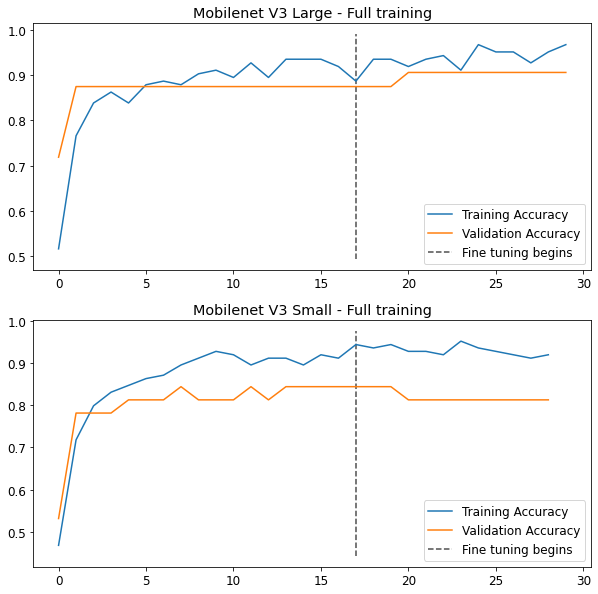

In [42]:
plt.figure(figsize=(10,10))

# Large model
total_history_large = {}
for metric in ['accuracy', 'val_accuracy']:
    total_history_large[metric] = history_large.history[metric] + history_FT_large.history[metric]

ax = plt.subplot(2,1,1)
plt.plot(total_history_large['accuracy'], label='Training Accuracy')
plt.plot(total_history_large['val_accuracy'], label='Validation Accuracy')
y_min, y_max = plt.ylim()
plt.vlines(base_epochs_large-1, ymin=y_min, ymax=y_max, label='Fine tuning begins', linestyles='--', colors=[0.3]*3)
plt.title("Mobilenet V3 Large - Full training")
plt.legend()


# Small model
total_history_small = {}
for metric in ['accuracy', 'val_accuracy']:
    total_history_small[metric] = history_small.history[metric] + history_FT_small.history[metric]
    
plt.subplot(2,1,2, sharex=ax)
plt.plot(total_history_small['accuracy'], label='Training Accuracy')
plt.plot(total_history_small['val_accuracy'], label='Validation Accuracy')
y_min, y_max = plt.ylim()
plt.vlines(base_epochs_large-1, ymin=y_min, ymax=y_max, label='Fine tuning begins', linestyles='--', colors=[0.3]*3)
plt.title("Mobilenet V3 Small - Full training")
plt.legend()

plt.show()

## Store models

In [46]:
Path(output_path_MN_large).parents[0].mkdir(exist_ok=True, parents=True)

In [47]:
model_large.save(output_path_MN_large)
model_small.save(output_path_MN_small)

INFO:tensorflow:Assets written to: ../models/pilot_mobilenet-v3-xfer/v1_poison_ivy_mobilenet-v3-large_classifier.tf/assets


/usr/local/lib/python3.6/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: ../models/pilot_mobilenet-v3-xfer/v1_poison_ivy_mobilenet-v3-small_classifier.tf/assets


/usr/local/lib/python3.6/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
